In [2]:
import warnings
warnings.filterwarnings("ignore")
import csv
import pandas as pd
import datetime 
import numpy as np
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns
from matplotlib import rcParams 
from sklearn.cluster import MiniBatchKMeans, KMeans
import math
import pickle
import os
import xgboost as xgb
import networkx as nx
import pdb
from pandas import HDFStore,DataFrame
from pandas import read_hdf
from scipy.sparse.linalg import svds, eigs
import gc
from pandas import read_hdf
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score


# RandomForestClassifier

In [3]:
#imporing the features file
df_final_train = read_hdf('Features.h5', 'train_df',mode='r')
df_final_test = read_hdf('Features.h5', 'test_df',mode='r')

In [4]:
y_train = df_final_train.indice
y_test = df_final_test.indice
df_final_train.shape, df_final_test.shape


((12110, 14), (3029, 14))

In [5]:
df_final_train.drop(['drug', 'protein','indice'],axis=1,inplace=True)
df_final_test.drop(['drug', 'protein','indice'],axis=1,inplace=True)

Estimators =  50 ---Train Score 0.9999177834415851 ----test Score 0.8855307895731017
Estimators =  100 ---Train Score 0.9999177834415851 ----test Score 0.8855307895731017
Estimators =  250 ---Train Score 0.9999177834415851 ----test Score 0.8855307895731017
Estimators =  450 ---Train Score 0.9999177834415851 ----test Score 0.8855307895731017
Estimators =  500 ---Train Score 0.9999177834415851 ----test Score 0.8855307895731017


Text(0.5, 1.0, 'Estimators vs score at depth of 5')

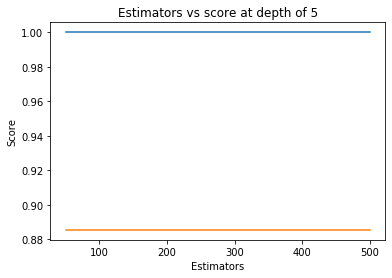

In [6]:
estimators = [50,100,250,450,500]
train_scores = []
test_scores = []
for i in estimators:
    clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=52, min_samples_split=120,
            min_weight_fraction_leaf=0.0, n_estimators=i, n_jobs=-1,random_state=25,verbose=0,warm_start=False)
    clf.fit(df_final_train,y_train)
    train_sc = f1_score(y_train,clf.predict(df_final_train))
    test_sc = f1_score(y_test,clf.predict(df_final_test))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('Estimators = ',i,'---Train Score',train_sc,'----test Score',test_sc)
plt.plot(estimators,train_scores,label='Train Score')
plt.plot(estimators,test_scores,label='Test Score')
plt.xlabel('Estimators')
plt.ylabel('Score')
plt.title('Estimators vs score at depth of 5')

In [7]:
clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=20, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=52, min_samples_split=120,
            min_weight_fraction_leaf=0.0, n_estimators=115, n_jobs=-1,random_state=25,verbose=0,warm_start=False)
clf.fit(df_final_train,y_train)
y_train_pred = clf.predict(df_final_test)



In [8]:
clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=21, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=52, min_samples_split=120,
            min_weight_fraction_leaf=0.0, n_estimators=450, n_jobs=-1,random_state=25,verbose=0,warm_start=False)
clf.fit(df_final_train,y_train)
y_train_pred = clf.predict(df_final_train)
y_test_pred = clf.predict(df_final_test)



In [9]:
# Pull out one tree from the forest And examine it
feature_list = list( df_final_test.columns)
from sklearn.tree import export_graphviz
import pydot
# Pull out one tree from the forest
tree =clf.estimators_[1]
# Export the image to a dot file
export_graphviz(tree, out_file = 'tree.dot', feature_names = feature_list, rounded = True, precision = 1)
# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('tree.dot')
# Write graph to a png file
graph.write_png('tree.png')


In [10]:

from sklearn.tree import export_graphviz
import pydot
rf_small = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=21, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=52, min_samples_split=120,
            min_weight_fraction_leaf=0.0, n_estimators=3, n_jobs=-1,random_state=25,verbose=0,warm_start=False)
rf_small.fit(df_final_train,y_train)
# Extract the small tree
tree_small = rf_small.estimators_[2]
# Save the tree as a png image
export_graphviz(tree_small, out_file = 'small_tree.dot', feature_names = feature_list, rounded = True, precision = 1)
(graph, ) = pydot.graph_from_dot_file('small_tree.dot')
graph.write_png('small_tree.png');

In [11]:
from sklearn.metrics import f1_score
print('Train f1 score',f1_score(y_train,y_train_pred))
print('Test f1 score',f1_score(y_test,y_test_pred))

Train f1 score 0.9999177834415851
Test f1 score 0.8855307895731017


In [12]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    annot_kws = {"ha": 'left',"va": 'top', "size":15}
    cmap=sns.light_palette("red")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f",annot_kws=annot_kws, xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", annot_kws=annot_kws, xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", annot_kws=annot_kws, xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()


In [13]:
tn, fp, fn, tp = confusion_matrix(y_train,y_train_pred).ravel()
print("True Negatives: ",tn)
print("False Positives: ",fp)
print("False Negatives: ",fn)
print("True Positives: ",tp)

True Negatives:  6028
False Positives:  0
False Negatives:  1
True Positives:  6081


In [14]:
Accuracy1 = (tn+tp)*100/(tp+tn+fp+fn) 
print("Accuracy :", format(Accuracy1), "%")

Accuracy : 99.99174236168456 %


In [15]:
tn, fp, fn, tp = confusion_matrix(y_test,y_test_pred).ravel()
print("True Negatives: ",tn)
print("False Positives: ",fp)
print("False Negatives: ",fn)
print("True Positives: ",tp)

True Negatives:  1554
False Positives:  0
False Negatives:  303
True Positives:  1172


In [16]:
Accuracy = (tn+tp)*100/(tp+tn+fp+fn) 
print("Accuracy :", format(Accuracy), "%")

Accuracy : 89.99669858038956 %


Test confusion_matrix


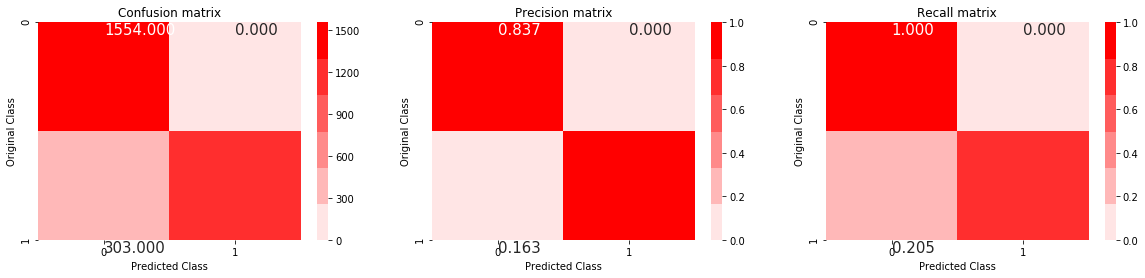

In [17]:
print('Test confusion_matrix')
plot_confusion_matrix(y_test,y_test_pred)

In [18]:
#predicting the train and test results
clf.fit(df_final_train,y_train)
y_train_pred = clf.predict(df_final_train)
y_test_pred = clf.predict(df_final_test)
from sklearn.metrics import f1_score
print('Train f1 score',f1_score(y_train,y_train_pred))
print('Test f1 score',f1_score(y_test,y_test_pred))

Train f1 score 0.9999177834415851
Test f1 score 0.8855307895731017


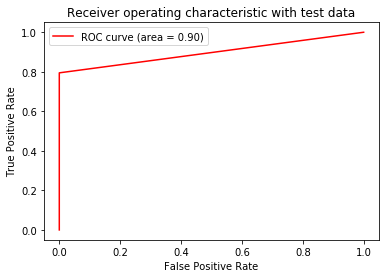

In [19]:
from sklearn.metrics import roc_curve, auc
fpr,tpr,ths = roc_curve(y_test,y_test_pred)
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='red',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()

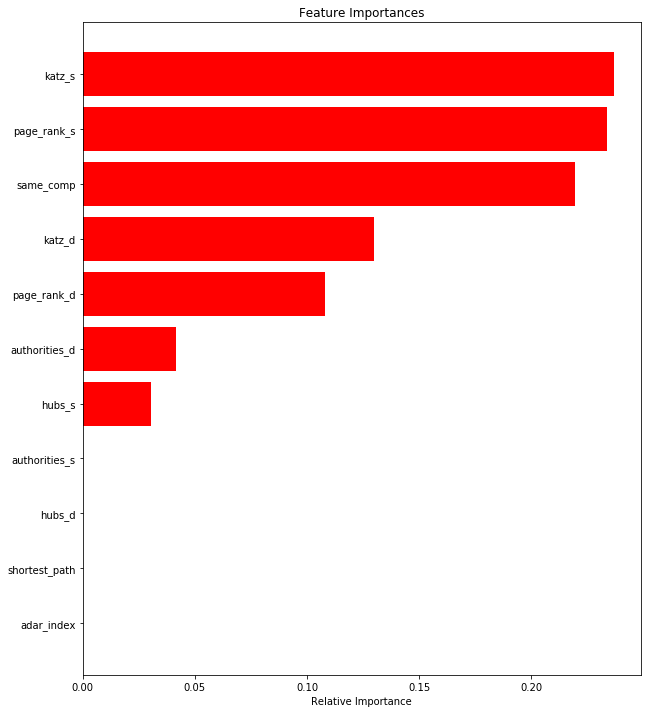

In [21]:
#Feature importance
features = df_final_train.columns
importances = clf.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()
